# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline
import seaborn.apionly as sns

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

In [25]:
np.random.seed(9001)
df = pd.read_csv('data/hw6_dataset.csv')

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [17]:
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

In [21]:
columns = data_train.columns
X_train = []
X_test = []
for column in columns[:-1]:
    maximum = data_train[column].max()
    minimum = data_train[column].min()
    X_train.append((data_train[column] - minimum) / (maximum - minimum))
    X_test.append((data_test[column] - minimum) / (maximum - minimum))
    
y_train = data_train[columns[-1]]
y_test = data_test[columns[-1]]

In [22]:
X_train = np.array(X_train).transpose()
X_test = np.array(X_test).transpose()
len(X_train)

51720

In [24]:
len(X_train[0])

117

In [28]:
reg = [10**i for i in range(-5, 6)]
clf = LogisticRegressionCV(Cs = reg)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [31]:
sum(clf.predict(X_test) == y_test) / len(y_test)

0.9949933820567417

In [32]:
sum(0 == y_test) / len(y_test)

0.99343960407435117

It's slightly better than classifying all the patinets to be 'label 0'. But the difference is not large enough becuase it is approximately only 0.1% differ in accuracy. The reason is that non-zero samples are too small.

In [37]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test,clf.predict(X_test))
print(confusion)

[[17257     6]
 [   81    33]]


In [41]:
true_negative = confusion[0][0] / (confusion[0][0] + confusion[0][1])
true_negative

0.99965243584544983

In [42]:
true_positive = confusion[1][1] / (confusion[1][0] + confusion[1][1])
true_positive

0.28947368421052633

For this case, true_negative means the accuracy rate identifying true normal people in all the people labeled in 0. The fitted model has 99.965% probability to be correct, which is approximate to 1 in the all 0's classifier.
However, true_positive means the accuracy in detecting true cancer people in all the people labeled in 1 (who are truly suffering from cancer). The fitted model has 28.9% probability to be correct, which is much higher than 0 in the all 0's classifier.

False positive rate is the proportion labeling as true (1 here) but actually it is false (0 here). It is equal to 1 - true negative rate. It is also equal to the $\frac{total \ number \ label \ as \ true (1) - true \ positive}{total \ number \ is \ actually \ false(0)}$

Higher false positive rate is undesirable for cancer detection since a lot of normal patients would be identified as cancer paitients, which might treat the patients wrongly, increase the burden of hospital and unnecessary worriness of patients.

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

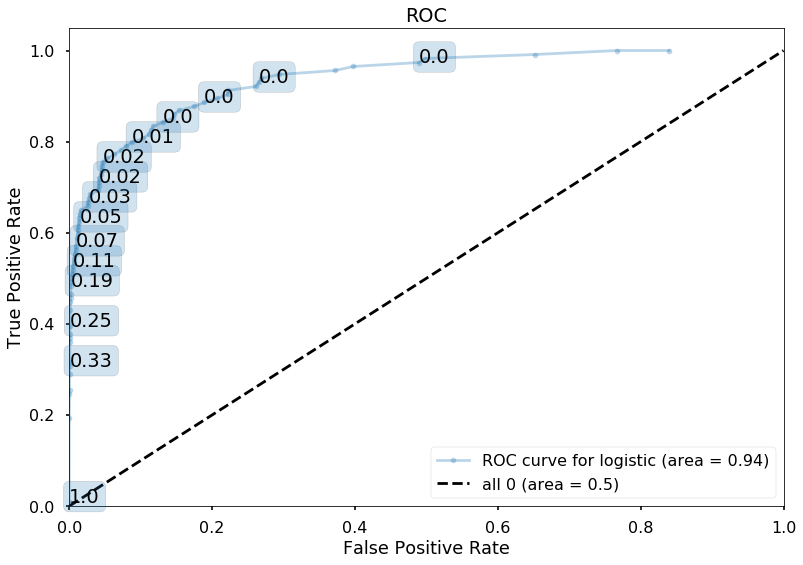

In [70]:
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--', label = 'all 0 (area = 0.5)')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")
ax=make_roc("logistic",clf, y_test, X_test, labe=10, skip=2)

In [59]:
fpr, tpr, thresholds=roc_curve(y_test, clf.predict_proba(X_test)[:,1])

In [79]:
# fpr == 0:
print("tpr: {} and threshold : {} when fpr = 0" .format(sum(tpr[fpr == 0]) / len(tpr[fpr == 0]), sum(thresholds[fpr == 0]) / len(thresholds[fpr == 0])))

tpr: 0.10087719298245613 and threshold : 0.8994363572128284 when fpr = 0


In [96]:
tmp = np.isclose(fpr, 0.1, atol = 1e-02)
print("tpr: {} and threshold : {} when fpr = 0.1" .format(sum(tpr[tmp]) / len(tpr[tmp]), sum(thresholds[tmp]) / len(thresholds[tmp])))

tpr: 0.8026315789473684 and threshold : 0.006429317023128855 when fpr = 0.1


In [99]:
tmp = np.isclose(fpr, 0.5, atol = 1e-02)
print("tpr: {} and threshold : {} when fpr = 0.5" .format(sum(tpr[tmp]) / len(tpr[tmp]), sum(thresholds[tmp]) / len(thresholds[tmp])))

tpr: 0.9780701754385965 and threshold : 0.00028073323756675075 when fpr = 0.5


In [108]:
print("tpr: {} and threshold : {} when fpr = 0.9" .format(sum(tpr[-2:]) / len(tpr[-2:]), sum(thresholds[-2:]) / len(thresholds[-2:])))

tpr: 1.0 and threshold : 7.758516261590155e-06 when fpr = 0.9


In [113]:
#  minimize 2*FN + FP
negative = sum(y_test == 0)
positive = sum(y_test == 1)
FP = fpr * negative
FN = (1 - tpr) * positive

In [122]:
table = 2 * FN + FP
index = np.where(table == min(table))

In [126]:
print(tpr[index])
print(fpr[index])
print(thresholds[index])

[ 0.42982456]
[ 0.00110062]
[ 0.24490975]


The ROC curve of fitted model looks better. Also, its AUC is close to the accuracy in Question 1. However, AUC of all 0's classifier is much less than accuracy in Question 1. This infers that using ROC/AUC might be a better measure to assess a model rather than simply looking at accuracy.

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [2]:
df2 = pd.read_csv('data/hw6_dataset_missing.csv')

In [3]:
df2.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,type
0,0,0.1290,-0.2160,0.2880,0.2370,-0.993,-0.9550,-1.620,-1.470,-1.0100,...,-1.1900,1.1000,0.395,2.060,-1.180,-2.8500,-1.290,-2.100,0.0121,0.0
1,1,0.0989,0.1160,0.3130,0.2810,-0.188,-0.2790,0.173,0.445,0.4320,...,-0.0181,0.2480,-0.869,-0.190,0.451,0.6980,0.363,1.030,-0.2490,0.0
2,2,0.0215,0.1590,0.5790,0.5020,-0.342,-0.2740,-0.172,-0.164,0.2160,...,0.0702,0.0200,0.397,-0.800,0.173,0.7380,0.465,0.440,-0.2880,0.0
3,3,-0.2170,-0.3570,-0.0539,-0.0688,0.445,0.6380,0.436,0.351,0.0401,...,NaN,0.0622,0.269,-0.217,-1.030,0.0276,0.472,-0.390,0.3660,0.0
4,4,-0.0846,0.0166,0.4240,0.3520,-0.259,-0.0947,0.119,-0.162,0.3020,...,0.7190,0.3250,-0.286,-0.528,-0.704,0.8530,0.953,-0.116,-0.1190,0.0


In [4]:
df2_drop = df2.dropna(how = 'any')

In [237]:
msk = np.random.rand(len(df2_drop)) < 0.75
data_train = df2_drop[msk]
data_test = df2_drop[~msk]

In [238]:
columns = data_train.columns
X_train = []
X_test = []
for column in columns[1:-1]:
    maximum = data_train[column].max()
    minimum = data_train[column].min()
    X_train.append((data_train[column] - minimum) / (maximum - minimum))
    X_test.append((data_test[column] - minimum) / (maximum - minimum))
    
y_train = data_train[columns[-1]]
y_test = data_test[columns[-1]]

In [239]:
X_train = np.array(X_train).transpose()
X_test = np.array(X_test).transpose()

In [240]:
reg = [10**i for i in range(-5, 6)]
clf_drop = LogisticRegressionCV(Cs = reg)
clf_drop.fit(X_train, y_train)

/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


LogisticRegressionCV(Cs=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [241]:
print("overall accuracy： {}" .format(sum(clf_drop.predict(X_test) == y_test) / len(y_test)))

overall accuracy： 0.9941348973607038


So tpr is also 1 in since overall accuracy is 1

In [26]:
df2_mean = df2.copy()
for column in df2.columns:
    df2_mean[column] = df2[column].fillna(df2_drop[column].mean())

In [27]:
msk = np.random.rand(len(df2_mean)) < 0.75
data_train = df2_mean[msk]
data_test = df2_mean[~msk]

In [28]:
columns = data_train.columns
X_train = []
X_test = []
for column in columns[1:-1]:
    maximum = data_train[column].max()
    minimum = data_train[column].min()
    X_train.append((data_train[column] - minimum) / (maximum - minimum))
    X_test.append((data_test[column] - minimum) / (maximum - minimum))
    
y_train = data_train[columns[-1]]
y_test = data_test[columns[-1]]

In [29]:
X_train = np.array(X_train).transpose()
X_test = np.array(X_test).transpose()

In [30]:
reg = [10**i for i in range(-5, 6)]
clf_mean = LogisticRegressionCV(Cs = reg)
clf_mean.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [31]:
print("overall accuracy： {}" .format(sum(clf_mean.predict(X_test) == y_test) / len(y_test)))

overall accuracy： 0.9929795918367347


In [32]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test,clf_mean.predict(X_test))
print("tpr: {}" .format(confusion[1][1] / (confusion[1][0] + confusion[1][1])))

tpr: 0.1568627450980392


In [33]:
column_ls = []
column_missing = []
for column in df2.columns[1:-1]:
    if sum(df2[column].isnull()) == 0:
        column_ls.append(column)
    else:
        column_missing.append(column)

In [34]:
df2_model = df2.copy()

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
from sklearn.linear_model import LinearRegression

for column in column_missing:
    tmp_tabel = df2.dropna(subset = [column])
    X_imp = tmp_tabel[column_ls]
    y_imp = tmp_tabel[column]
    regress = LinearRegression()
    regress.fit(X_imp,y_imp)
    y_hat = regress.predict(X_imp)
    X_missing = df2[df2[column].isnull()][column_ls]
    y_missing = regress.predict(X_missing)
    y_missing_noise = y_missing + np.random.normal(loc=0,scale=np.sqrt(mean_squared_error(y_imp,y_hat)),size=y_missing.shape[0])
    
    missing_index = df2[df2[column].isnull()].index
    missing_series = pd.Series(data = y_missing_noise, index = missing_index)
    
    df2_model[column] = df2_model[column].fillna(missing_series)

In [37]:
df2_model.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,type
0,0,0.1290,-0.2160,0.2880,0.2370,-0.993,-0.9550,-1.620,-1.470,-1.0100,...,-1.190000,1.1000,0.395,2.060,-1.180,-2.8500,-1.290,-2.100,0.0121,0.0
1,1,0.0989,0.1160,0.3130,0.2810,-0.188,-0.2790,0.173,0.445,0.4320,...,-0.018100,0.2480,-0.869,-0.190,0.451,0.6980,0.363,1.030,-0.2490,0.0
2,2,0.0215,0.1590,0.5790,0.5020,-0.342,-0.2740,-0.172,-0.164,0.2160,...,0.070200,0.0200,0.397,-0.800,0.173,0.7380,0.465,0.440,-0.2880,0.0
3,3,-0.2170,-0.3570,-0.0539,-0.0688,0.445,0.6380,0.436,0.351,0.0401,...,0.625555,0.0622,0.269,-0.217,-1.030,0.0276,0.472,-0.390,0.3660,0.0
4,4,-0.0846,0.0166,0.4240,0.3520,-0.259,-0.0947,0.119,-0.162,0.3020,...,0.719000,0.3250,-0.286,-0.528,-0.704,0.8530,0.953,-0.116,-0.1190,0.0


In [38]:
msk = np.random.rand(len(df2_model)) < 0.75
data_train = df2_model[msk]
data_test = df2_model[~msk]

In [39]:
columns = data_train.columns
X_train = []
X_test = []
for column in columns[1:-1]:
    maximum = data_train[column].max()
    minimum = data_train[column].min()
    X_train.append((data_train[column] - minimum) / (maximum - minimum))
    X_test.append((data_test[column] - minimum) / (maximum - minimum))
    
y_train = data_train[columns[-1]]
y_test = data_test[columns[-1]]

In [40]:
X_train = np.array(X_train).transpose()
X_test = np.array(X_test).transpose()

In [41]:
reg = [10**i for i in range(-5, 6)]
clf_model = LogisticRegressionCV(Cs = reg)
clf_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [42]:
print("overall accuracy： {}" .format(sum(clf_model.predict(X_test) == y_test) / len(y_test)))

overall accuracy： 0.9931707317073171


In [43]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test,clf_mean.predict(X_test))
print("tpr: {}" .format(confusion[1][1] / (confusion[1][0] + confusion[1][1])))

tpr: 0.02564102564102564


1. Directly removing NA would simply remove all the samples that are labeled as 1. So the overall accuracy and true positive rate are high but it doesn't make sense. Since after deleting the NA data, there are only 1000+ samples left, which are much fewer than the original samples. And there is no samples for cancer patients. 

2. Imputation by means is somewhat rational than simply removing NA and the computational complexity is low(O(len(samples)) to calbulate mean). Right now there are samples for true cancer patients. However, a lot of missing data appears in true cancer patients, so imputation simply by means can not help fit a model that could identify true cancer. So the true positive rate is relatively low.

3. Imputation by model has relatively high overall accuracy and true positive rate. However, the computational complexity is tremendously huge since we have to fit a regression model for every missing column. (O(# missing columns * # total_samples))

## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.


1. $l_i(\theta_i) = \log f(y_i|\theta_i) = \log h(y_i)e^{y_i\theta_i - b(\theta_i)} = \log h(y_i) + \log (y_i\theta_i - b(\theta_i))$, $l(\theta) = \sum_i l_i(\theta_i)$

2. $$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \theta_i}{\partial \mu_i} \frac{\partial \mu_i}{\partial \eta_i} \frac{\partial \eta_i}{\partial \beta_j}$$

3. $\frac{\partial l_i}{\partial \theta_i} = y_i - b'(\theta_i) = y_i - \mu_i$, $\frac{\partial \eta_i}{\partial \beta_j} = x_j$

4. $\frac{\partial \theta_i}{\partial \mu_i} = (\frac{\partial \mu_i}{\partial \theta_i})^{-1} = (b''(\theta_i))^{-1}$ since $\mu_i = b'(\theta_i)$

5. $\frac{\partial \mu_i}{\partial \eta_i} = (\frac{\partial \eta_i}{\partial \mu_i})^{-1} = (g'(\mu_i))^{-1}$

6. $\frac{\partial l_i}{\partial \beta_j} = (y_i - \mu_i) (b''(\theta_i))^{-1} (g'(\mu_i))^{-1} x_j$.

    So $$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
    
    where $D$ is the diagonal matrix of  $\frac{\partial \theta_i}{\partial \mu_i}$ and $V$ is the diagonal matrix of variances of each observation since $b''(\theta) = Var(y|\theta)$.

7. canonical link function infers $\theta = x^{T} \beta = \eta = g(\mu)$,

$$\frac{\partial \mu_i}{\partial \eta_i} = (\frac{\partial \eta_i}{\partial \mu_i})^{-1} = (\frac{\partial \theta_i}{\partial \mu_i})^{-1}$$

Therefore, $$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \theta_i}{\partial \mu_i} \frac{\partial \mu_i}{\partial \eta_i} \frac{\partial \eta_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \theta_i}{\partial \mu_i} (\frac{\partial \theta_i}{\partial \mu_i})^{-1} \frac{\partial \eta_i}{\partial \beta_j} =  \frac{\partial l_i}{\partial \mu_i} \frac{\partial \eta_i}{\partial \beta_j}$$

So $$\nabla_{\beta} l(\beta) = X(Y - \mu) = 0$$


For logistic regression, the link function is logit, i.e., $g(\mu) = logit(\mu) = \log(\frac{\mu}{1 - \mu}) = \eta = x^{T} \beta $

$$\mu = logit^{-1}(x^{T} \beta) = \frac{exp(x^{T}\beta)}{1 + exp(x^{T}\beta)}$$

Since for logisitic regression, the observation given the probability $\mu$ are drawn independetly from a Bernoulli distribution. So $var(y|\theta_i) = \mu_i(1-\mu_i)$

$$\frac{\partial \theta_i}{\partial \mu_i} = (b''(\theta_i))^{-1} = (\mu_i(1-\mu_i))^{-1}$$

Also, $$\frac{\partial \mu_i}{\partial \eta_i} = (\frac{\partial \eta_i}{\partial \mu_i})^{-1} = (g'(\mu_i))^{-1} = (\frac{1}{\mu_i(1-\mu_i)})^{-1}$$

So $$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \eta_i}{\partial \beta_j}$$

$$\nabla_{\beta} l(\beta) = X(Y - \mu) = \sum_i x_i[y_i - \frac{exp(x^{T}\beta)}{1 + exp(x^{T}\beta)}]= 0$$